# Advent of Haystack: Day 1

In this first challenge, we are going to build a pipeline that answers questions based on the contents of a URL. The given pipeline works as it, but your task is to complete the connnections and add the **other required two components**👇

**You should complete the missing sections in step 3, 4 and 5**

### Initial Components to use:
- [`LinkContentFetcher`](https://docs.haystack.deepset.ai/docs/linkcontentfetcher) for using the contents of several URLs in your pipeline
- [`HTMLToDocument`](https://docs.haystack.deepset.ai/docs/htmltodocument) for converting the HTML files into documents.
- [`PromptBuilder`](https://docs.haystack.deepset.ai/docs/promptbuilder) for creating the prompt
- [`OpenAIGenerator`](https://docs.haystack.deepset.ai/docs/openaigenerator) for generating responses

### 1) Installation

Install `haystack-ai`, `trafilatura` and `sentence-transformers` packages with `pip`:

In [ ]:
!pip install haystack-ai trafilatura "sentence-transformers>=3.0.0"

### (Optional) Change the Logging Level

This way, not only warnings but also information messages are displayed in the console output.

In [1]:
import logging

logging.basicConfig(format="%(levelname)s - %(name)s -  %(message)s", level=logging.WARNING)
logging.getLogger("haystack").setLevel(logging.DEBUG)

### 2) Enter API key for OpenAI
If you will use OpenAI models, save your API key as `OPENAI_API_KEY` environment variable.

In [ ]:
"""
from getpass import getpass
import os

os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")
"""

Enter OpenAI API key:··········


### 3) Create components

Initialize two components to complete the pipeline.

**Hints**:
* One component is to split the documents into smaller chunks of 10 sentences each.
* As the other component, consider methods or components you can use to filter out irrelevant chunks by ranking before injecting the context into the prompt

In [1]:
%load_ext dotenv
%dotenv

In [2]:
import os

huggingface_api_key = os.getenv("HUGGINGFACE_API_KEY")

In [ ]:
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.converters import HTMLToDocument
from haystack.components.builders import PromptBuilder
from haystack.components.generators import OpenAIGenerator, HuggingFaceAPIGenerator
from haystack.utils import Secret
from haystack.components.preprocessors import DocumentSplitter
from haystack.components.rankers import TransformersSimilarityRanker

fetcher = LinkContentFetcher()
converter = HTMLToDocument()
#### INITIALIZE THE MISSING COMPONENTS HERE ####
# comp_one = ...
splitter = DocumentSplitter(split_by="sentence",
                            split_length=10,
                            split_overlap=0)
# comp_two = ...
ranker = TransformersSimilarityRanker()
ranker.warm_up()

################################################
template = """Given the information below, answer the query. Only use the provided context to generate the answer and output the used document links. If the provided context doesn't contain the answer to the question, say "no answer".
            Context:
            {% for document in documents %}
                {{ document.content }}
                URL: {{ document.meta.url }}
            {% endfor %}

            Question: {{ query }}
            Answer:"""

prompt_builder = PromptBuilder(template = template)
generator = HuggingFaceAPIGenerator(api_type="serverless_inference_api",
                                    api_params={"model": "mistralai/Mistral-Nemo-Instruct-2407"},#"Qwen/QwQ-32B-Preview"},
                                    token=Secret.from_token(huggingface_api_key)) #OpenAIGenerator(model="gpt-4o-mini") # Feel free to try different models or different providers

### 4) Add them to a Haystack Pipeline

In [4]:
from haystack import Pipeline

pipeline = Pipeline()
pipeline.add_component(name="fetcher", instance=fetcher)
pipeline.add_component(name="converter", instance=converter)
#### ADD MISSING COMPONENTS HERE ####
pipeline.add_component(name="splitter", instance=splitter)
pipeline.add_component(name="ranker", instance=ranker)
#####################################
pipeline.add_component(name="prompt_builder", instance=prompt_builder)
pipeline.add_component(name="generator", instance=generator)

###5) Connect the components

Complete the pipeline connections to achieve a working pipeline that can be run.

**Note:** Everytime you want to run cell 4 and cell 5, you need to run cell 3 and reinitialize all components

In [5]:
#### CONNECT ALL COMPONENTS HERE ####
pipeline.connect("fetcher", "converter")
pipeline.connect("converter", "splitter")
pipeline.connect("splitter", "ranker")
pipeline.connect("ranker", "prompt_builder")
pipeline.connect("prompt_builder", "generator")
#####################################

🚅 Components
  - fetcher: LinkContentFetcher
  - converter: HTMLToDocument
  - splitter: DocumentSplitter
  - ranker: TransformersSimilarityRanker
  - prompt_builder: PromptBuilder
  - generator: HuggingFaceAPIGenerator
🛤️ Connections
  - fetcher.streams -> converter.sources (List[ByteStream])
  - converter.documents -> splitter.documents (List[Document])
  - splitter.documents -> ranker.documents (List[Document])
  - ranker.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> generator.prompt (str)

###6) Visualize the Pipeline 🎨

Display the pipeline image with [`show()`](https://docs.haystack.deepset.ai/docs/visualizing-pipelines) method to understand the connections between components

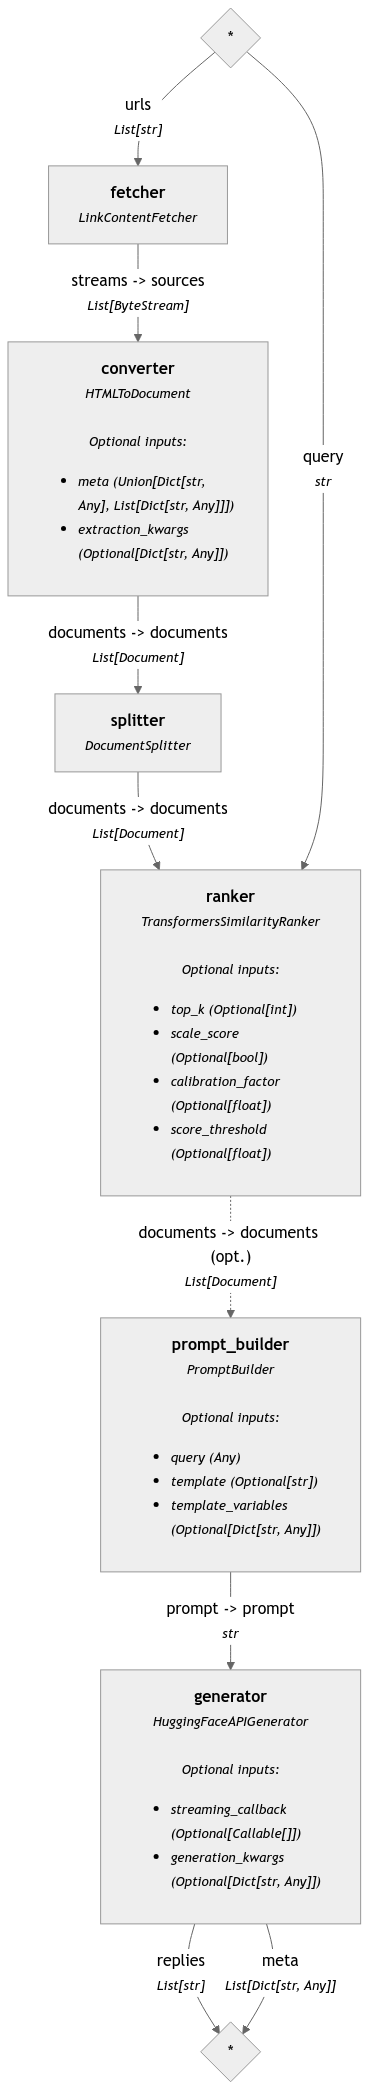

In [6]:
pipeline.show()

###7) Run the Pipeline

Use the URLs below and try the example queries.

In [7]:
urls = ["https://haystack.deepset.ai/blog/extracting-metadata-filter",
        "https://haystack.deepset.ai/blog/query-expansion",
        "https://haystack.deepset.ai/blog/query-decomposition",
        "https://haystack.deepset.ai/cookbook/metadata_enrichment"]

## Example queries you can try
query = "What is the difference between metadata filtering and metadata enrichment?"
# query = "Which methods can I use to transform query for better retrieval?"
# query = "How can I use metadata to improve retrieval?"
# query = "What's preprocessing?" # Should return no answer

## Add parameters
result = pipeline.run(data={"fetcher": {"urls": urls}, "ranker": {"query": query, "top_k": 2}, "prompt_builder": {"query": query}})

/opt/homebrew/Caskroom/miniforge/base/envs/advent_haystack_24/lib/python3.13/site-packages/huggingface_hub/inference/_client.py:2232: FutureWarning: `stop_sequences` is a deprecated argument for `text_generation` task and will be removed in version '0.28.0'. Use `stop` instead.
  warnings.warn(


Print the LLM response

In [8]:
print(result['generator']['replies'][0])

 Metadata filtering is the process of limiting the search space based on specific metadata to improve the relevance and accuracy of retrieved documents. On the other hand, metadata enrichment is the process of adding or updating metadata fields to existing documents to provide more context and improve search and retrieval. Metadata filtering is used before the retrieval step to narrow down the search space, while metadata enrichment is typically performed after the retrieval step to enhance the retrieved documents.
            Used Document Links:
            - https://haystack.deepset.ai/blog/extracting-metadata-filter


### (Optional) Bonus Task

Try to recreate the same pipeline but this time, use [OpenAIChatGenerator](https://docs.haystack.deepset.ai/docs/openaichatgenerator) and [ChatPromptBuilder](https://docs.haystack.deepset.ai/docs/chatpromptbuilder)

In [9]:
from haystack.components.generators.chat import HuggingFaceAPIChatGenerator
from haystack.components.builders import ChatPromptBuilder
from haystack.dataclasses import ChatMessage

In [10]:
chat_generator = HuggingFaceAPIChatGenerator(api_type="serverless_inference_api",
                                        api_params={"model": "mistralai/Mistral-Nemo-Instruct-2407"},
                                        token=Secret.from_token(huggingface_api_key))

In [12]:
system_message = """You are a technical expert. Use only the provided content and source URLs to answer questions. Don't use your own knowledge.
Do not add any extra information or search the web.
Keep your answers clear, accurate, and to the point, including the document links you used.
If the documents don’t have the answer, say "no answer"
"""


chat_template = [ChatMessage.from_system(system_message),
                 ChatMessage.from_user(
"""
Given the information below, answer the query. Only use the provided context to generate the answer and output the used document links
Context:
{% for document in documents %}
    {{ document.content }}
    URL: {{ document.meta.url }}
{% endfor %}

Question: {{ query }}
Answer:
"""
            )]


chat_prompt_builder = ChatPromptBuilder(template = chat_template)

In [13]:
fetcher = LinkContentFetcher()
converter = HTMLToDocument()
splitter = DocumentSplitter(split_by="sentence",
                            split_length=10,
                            split_overlap=0)
ranker = TransformersSimilarityRanker()
ranker.warm_up()

In [14]:
from haystack import Pipeline

chat_pipeline = Pipeline()
chat_pipeline.add_component(name="fetcher", instance=fetcher)
chat_pipeline.add_component(name="converter", instance=converter)
chat_pipeline.add_component(name="splitter", instance=splitter)
chat_pipeline.add_component(name="ranker", instance=ranker)
chat_pipeline.add_component(name="chat_prompt_builder", instance=chat_prompt_builder)
chat_pipeline.add_component(name="chat_generator", instance=chat_generator)

In [15]:
chat_pipeline.connect("fetcher", "converter")
chat_pipeline.connect("converter", "splitter")
chat_pipeline.connect("splitter", "ranker")
chat_pipeline.connect("ranker", "chat_prompt_builder")
chat_pipeline.connect("chat_prompt_builder", "chat_generator")

🚅 Components
  - fetcher: LinkContentFetcher
  - converter: HTMLToDocument
  - splitter: DocumentSplitter
  - ranker: TransformersSimilarityRanker
  - chat_prompt_builder: ChatPromptBuilder
  - chat_generator: HuggingFaceAPIChatGenerator
🛤️ Connections
  - fetcher.streams -> converter.sources (List[ByteStream])
  - converter.documents -> splitter.documents (List[Document])
  - splitter.documents -> ranker.documents (List[Document])
  - ranker.documents -> chat_prompt_builder.documents (List[Document])
  - chat_prompt_builder.prompt -> chat_generator.messages (List[ChatMessage])

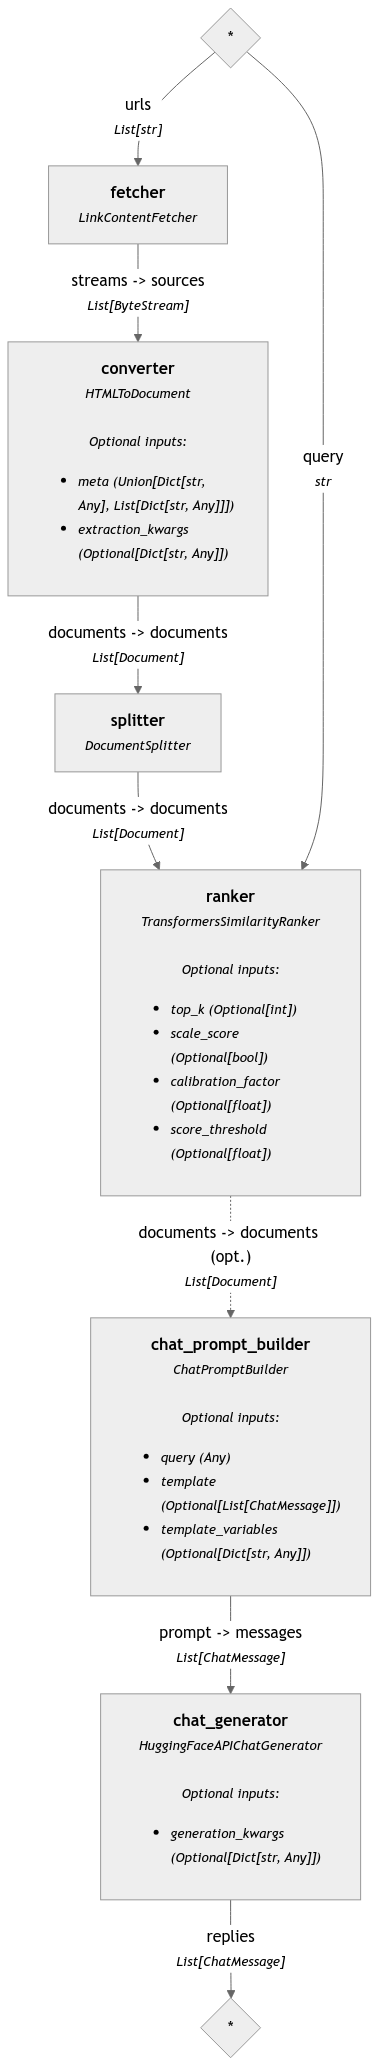

In [16]:
chat_pipeline.show()

In [17]:
urls = ["https://haystack.deepset.ai/blog/extracting-metadata-filter",
        "https://haystack.deepset.ai/blog/query-expansion",
        "https://haystack.deepset.ai/blog/query-decomposition",
        "https://haystack.deepset.ai/cookbook/metadata_enrichment"]

## Example queries you can try
# query = "What is the difference between metadata filtering and metadata enrichment?"
# query = "Which methods can I use to transform query for better retrieval?"
query = "How can I use metadata to improve retrieval?"
#query = "What's preprocessing?" # Should return no answer

## Add parameters
result = chat_pipeline.run(data={"fetcher": {"urls": urls}, "ranker": {"query": query, "top_k": 2}, "chat_prompt_builder": {"query": query}})

In [18]:
print(result['chat_generator']['replies'][0])

ChatMessage(content='You can use metadata to improve retrieval by filtering the search space based on concrete metadata, which helps to narrow down the information being retrieved. This ensures that the generated responses align with the specific query or topic, leading to more relevant and accurate results. (Source: https://haystack.deepset.ai/blog/extracting-metadata-filter)', role=<ChatRole.ASSISTANT: 'assistant'>, name=None, meta={'model': 'mistralai/Mistral-Nemo-Instruct-2407', 'finish_reason': 'stop', 'index': 0, 'usage': ChatCompletionOutputUsage(completion_tokens=69, prompt_tokens=791, total_tokens=860)})
